ResNet 网络是在 2015年 由微软实验室提出，斩获当年ImageNet竞赛中分类任务第一名，目标检测第一名。获得COCO数据集中目标检测第一名，图像分割第一名。

在ResNet网络的创新点：

# 1.提出 Residual 结构（残差结构），并搭建超深的网络结构（可突破1000层）

# 2.使用 Batch Normalization 加速训练（丢弃dropout）


# 搭建模型

In [1]:
import torch.nn as nn
import torch

#定义18,34残差结构
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

#定义50,101,152残差结构
class Bottleneck(nn.Module):
    """
    注意：原论文中，在虚线残差结构的主分支上，第一个1x1卷积层的步距是2，第二个3x3卷积层步距是1。
    但在pytorch官方实现过程中是第一个1x1卷积层的步距是1，第二个3x3卷积层步距是2，
    这么做的好处是能够在top1上提升大概0.5%的准确率。
    可参考Resnet v1.5 https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch
    """
    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None,
                 groups=1, width_per_group=64):
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=width,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, groups=groups,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=width, out_channels=out_channel*self.expansion,
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out

#----------------------------------------------------------------------------------------------------
class ResNet(nn.Module):

    def __init__(self,
                 block,
                 blocks_num,
                 num_classes=1000,
                 include_top=True,
                 groups=1,
                 width_per_group=64):
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.groups = groups
        self.width_per_group = width_per_group
#7X7卷积
        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
#最大池化
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#conv2_x
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
#conv3_x
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
#conv4_x
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
#conv5_x
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
    
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel,
                            channel,
                            downsample=downsample,
                            stride=stride,
                            groups=self.groups,
                            width_per_group=self.width_per_group))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel,
                                channel,
                                groups=self.groups,
                                width_per_group=self.width_per_group))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x


def resnet34(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet34-333f7ec4.pth
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet50(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet50-19c8e357.pth
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet101(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)


def resnext50_32x4d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth
    groups = 32
    width_per_group = 4
    return ResNet(Bottleneck, [3, 4, 6, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


def resnext101_32x8d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth
    groups = 32
    width_per_group = 8
    return ResNet(Bottleneck, [3, 4, 23, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


D:\ANnaconda\envs\HBHB\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 模型训练

In [9]:
import os
import sys
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm import tqdm


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    "val": transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

image_path =  "../data/flower_data"
train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                     transform=data_transform["train"])
train_num = len(train_dataset)

# {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
flower_list = train_dataset.class_to_idx
cla_dict = dict((val, key) for key, val in flower_list.items())
# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)

batch_size = 16


train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=0)

validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                                        transform=data_transform["val"])
val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=0)

print("using {} images for training, {} images for validation.".format(train_num,
                                                                       val_num))

net = resnet34()#不传入参数，采取迁移学习

#____________________迁移学习_____________________________
# load pretrain weights
# download url: https://download.pytorch.org/models/resnet34-333f7ec4.pth
model_weight_path = "./resnet34-pre.pth"
assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)

net.load_state_dict(torch.load(model_weight_path, map_location='cpu'))
# for param in net.parameters():
#     param.requires_grad = False

# change fc layer structure
in_channel = net.fc.in_features
net.fc = nn.Linear(in_channel, 5) #1000--->5
net.to(device)
#----------------------------------------------------------

# define loss function
loss_function = nn.CrossEntropyLoss()

# construct an optimizer
params = [p for p in net.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.0001)

epochs = 30
best_acc = 0.0
save_path = './resNet34.pth'
train_steps = len(train_loader)
for epoch in range(epochs):
    # train
    net.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
        logits = net(images.to(device))
        loss = loss_function(logits, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 epochs,
                                                                 loss)

    # validate
    net.eval()
    acc = 0.0  # accumulate accurate number / epoch
    with torch.no_grad():
        val_bar = tqdm(validate_loader, file=sys.stdout)
        for val_data in val_bar:
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            # loss = loss_function(outputs, test_labels)
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

            val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1,
                                                       epochs)

    val_accurate = acc / val_num
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
          (epoch + 1, running_loss / train_steps, val_accurate))

    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(net.state_dict(), save_path)

print('Finished Training')

using cuda:0 device.
using 3306 images for training, 364 images for validation.
valid epoch[1/30]: 100%|███████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.92it/s]
[epoch 1] train_loss: 0.505  val_accuracy: 0.890
valid epoch[2/30]: 100%|███████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.93it/s]
[epoch 2] train_loss: 0.338  val_accuracy: 0.887
valid epoch[3/30]: 100%|███████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.85it/s]
[epoch 3] train_loss: 0.275  val_accuracy: 0.912
valid epoch[4/30]: 100%|███████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.84it/s]
[epoch 4] train_loss: 0.245  val_accuracy: 0.901
valid epoch[5/30]: 100%|███████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.02it/s]
[epoch 5] train_loss: 0.229  val_accuracy: 0.920
valid epoch[6/30]: 100%|███████████████████████████████████████████████████

# 单张图片预测

class: daisy        prob: 0.00014413491589948535
class: dandelion    prob: 3.616520552895963e-05
class: roses        prob: 0.9608967900276184
class: sunflowers   prob: 7.196955266408622e-05
class: tulips       prob: 0.038850970566272736


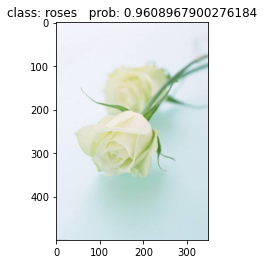

In [11]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# load image
img_path = "./1.jpg"
assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
img = Image.open(img_path).convert('RGB')
plt.imshow(img)
# [N, C, H, W]
img = data_transform(img)
# expand batch dimension
img = torch.unsqueeze(img, dim=0)

# read class_indict
json_path = './class_indices.json'
assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

with open(json_path, "r") as f:
    class_indict = json.load(f)

# create model
model = resnet34(num_classes=5).to(device)

# load model weights
weights_path = "./resNet34.pth"
assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
model.load_state_dict(torch.load(weights_path, map_location=device))

# prediction
model.eval()
with torch.no_grad():
    # predict class
    output = torch.squeeze(model(img.to(device))).cpu()
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()

print_res = "class: {}   prob: {}".format(class_indict[str(predict_cla)],
                                             predict[predict_cla].numpy())
plt.title(print_res)
for i in range(len(predict)):
    print("class: {:10}   prob: {}".format(class_indict[str(i)],
                                              predict[i].numpy()))
plt.show()

---

# ResNetXt

# 模型训练

In [5]:
import os
import sys
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm import tqdm


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    "val": transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

image_path =  "../data/flower_data"
train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                     transform=data_transform["train"])
train_num = len(train_dataset)

# {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
flower_list = train_dataset.class_to_idx
cla_dict = dict((val, key) for key, val in flower_list.items())
# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)

batch_size = 16


train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=0)

validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                                        transform=data_transform["val"])
val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=0)

print("using {} images for training, {} images for validation.".format(train_num,
                                                                       val_num))

net = resnext50_32x4d()#不传入参数，采取迁移学习

#____________________迁移学习_____________________________
# load pretrain weights
# download url: https://download.pytorch.org/models/resnet34-333f7ec4.pth
model_weight_path = "./resnext50_32x4d.pth"
assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)

net.load_state_dict(torch.load(model_weight_path, map_location='cpu'))

#冻结所有权重，只训练全连接
# for param in net.parameters():
#     param.requires_grad = False

# change fc layer structure
in_channel = net.fc.in_features
net.fc = nn.Linear(in_channel, 5) #1000--->5
net.to(device)
#----------------------------------------------------------

# define loss function
loss_function = nn.CrossEntropyLoss()

# construct an optimizer
params = [p for p in net.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.0001)

epochs = 2
best_acc = 0.0
save_path = './resnext50_32x4d_A.pth'
train_steps = len(train_loader)
for epoch in range(epochs):
    # train
    net.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
        logits = net(images.to(device))
        loss = loss_function(logits, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 epochs,
                                                                 loss)

    # validate
    net.eval()
    acc = 0.0  # accumulate accurate number / epoch
    with torch.no_grad():
        val_bar = tqdm(validate_loader, file=sys.stdout)
        for val_data in val_bar:
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            # loss = loss_function(outputs, test_labels)
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

            val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1,
                                                       epochs)

    val_accurate = acc / val_num
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
          (epoch + 1, running_loss / train_steps, val_accurate))

    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(net.state_dict(), save_path)

print('Finished Training')

using cuda:0 device.
using 3306 images for training, 364 images for validation.
valid epoch[1/2]: 100%|████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.87it/s]
[epoch 1] train_loss: 0.454  val_accuracy: 0.907
valid epoch[2/2]: 100%|████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.10it/s]
[epoch 2] train_loss: 0.294  val_accuracy: 0.934
Finished Training


# 单张预测  (有bug)


class: daisy        prob: 0.04988723620772362
class: dandelion    prob: 0.0031569236889481544
class: roses        prob: 0.9234704375267029
class: sunflowers   prob: 0.002095297444611788
class: tulips       prob: 0.021390123292803764


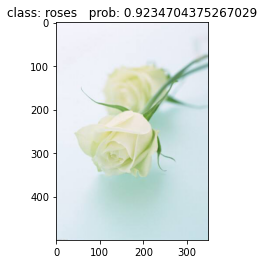

In [6]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# load image
img_path = "./1.jpg"
assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
img = Image.open(img_path).convert('RGB')
plt.imshow(img)
# [N, C, H, W]
img = data_transform(img)
# expand batch dimension
img = torch.unsqueeze(img, dim=0)

# read class_indict
json_path = './class_indices.json'
assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

with open(json_path, "r") as f:
    class_indict = json.load(f)

# create model
model = resnext50_32x4d(num_classes=5).to(device)

# load model weights
weights_path = "./resnext50_32x4d_A.pth"
assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
model.load_state_dict(torch.load(weights_path, map_location=device))

# prediction
model.eval()
with torch.no_grad():
    # predict class
    output = torch.squeeze(model(img.to(device))).cpu()
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()

print_res = "class: {}   prob: {}".format(class_indict[str(predict_cla)],
                                             predict[predict_cla].numpy())
plt.title(print_res)
for i in range(len(predict)):
    print("class: {:10}   prob: {}".format(class_indict[str(i)],
                                              predict[i].numpy()))
plt.show()

-----

# 批量预测

In [11]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms





device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# load image
# 指向需要遍历预测的图像文件夹
imgs_root = "../data/imgs_batch"
assert os.path.exists(imgs_root), f"file: '{imgs_root}' dose not exist."
# 读取指定文件夹下所有jpg图像路径
img_path_list = [os.path.join(imgs_root, i) for i in os.listdir(imgs_root) if i.endswith(".jpg")]

# read class_indict
json_path = './class_indices.json'
assert os.path.exists(json_path), f"file: '{json_path}' dose not exist."

json_file = open(json_path, "r")
class_indict = json.load(json_file)

# create model
model = resnext50_32x4d(num_classes=5).to(device)

# load model weights
weights_path = "./resnext50_32x4d_A.pth"
assert os.path.exists(weights_path), f"file: '{weights_path}' dose not exist."
model.load_state_dict(torch.load(weights_path, map_location=device))

# prediction
model.eval()
batch_size = 15  # 每次预测时将多少张图片打包成一个batch
with torch.no_grad():
    for ids in range(0, len(img_path_list) // batch_size):
        img_list = []
        for img_path in img_path_list[ids * batch_size: (ids + 1) * batch_size]:
            assert os.path.exists(img_path), f"file: '{img_path}' dose not exist."
            img = Image.open(img_path)
            img = data_transform(img)
            img_list.append(img)

        # batch img
        # 将img_list列表中的所有图像打包成一个batch
        batch_img = torch.stack(img_list, dim=0)
        # predict class
        output = model(batch_img.to(device)).cpu()
        predict = torch.softmax(output, dim=1)
        probs, classes = torch.max(predict, dim=1)

        for idx, (pro, cla) in enumerate(zip(probs, classes)):
            print("image: {}  class: {}  prob: {:.3}".format(img_path_list[ids * batch_size + idx],
                                                             class_indict[str(cla.numpy())],
                                                             pro.numpy()))



image: ../data/imgs_batch\1 (1).jpg  class: sunflowers  prob: 0.999
image: ../data/imgs_batch\1 (10).jpg  class: tulips  prob: 1.0
image: ../data/imgs_batch\1 (11).jpg  class: tulips  prob: 0.999
image: ../data/imgs_batch\1 (12).jpg  class: tulips  prob: 0.956
image: ../data/imgs_batch\1 (13).jpg  class: dandelion  prob: 1.0
image: ../data/imgs_batch\1 (14).jpg  class: roses  prob: 1.0
image: ../data/imgs_batch\1 (15).jpg  class: daisy  prob: 0.996
image: ../data/imgs_batch\1 (2).jpg  class: sunflowers  prob: 0.995
image: ../data/imgs_batch\1 (3).jpg  class: dandelion  prob: 1.0
image: ../data/imgs_batch\1 (4).jpg  class: roses  prob: 1.0
image: ../data/imgs_batch\1 (5).jpg  class: dandelion  prob: 1.0
image: ../data/imgs_batch\1 (6).jpg  class: daisy  prob: 0.636
image: ../data/imgs_batch\1 (7).jpg  class: daisy  prob: 0.998
image: ../data/imgs_batch\1 (8).jpg  class: sunflowers  prob: 1.0
image: ../data/imgs_batch\1 (9).jpg  class: roses  prob: 0.993
